In [1]:
import VisionTransformer as vit

import copy
import datetime
import h5py
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F

from datetime import datetime
from gc import collect
from os import cpu_count
from sklearn.model_selection import train_test_split
from time import sleep
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
from tqdm import tqdm

In [2]:
random_seed = 1
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
cudnn.benchmark = False

In [3]:
collect()
torch.cuda.empty_cache()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Running on device: {device}")

Running on device: cpu


## Preparing dataset

In [4]:
dspl = h5py.File('displacements_25.h5')["data"]
trac = h5py.File('tractions_25.h5')["data"]

dspl = np.moveaxis(np.array(dspl),3 ,1)
trac = np.moveaxis(np.array(trac),3 ,1)

X_train = torch.from_numpy(dspl).double()
Y_train = torch.from_numpy(trac).double()

In [5]:
X_train.shape

torch.Size([25, 2, 104, 104])

In [6]:
train_set = TensorDataset(X_train, Y_train)
# val_set = TensorDataset(X_val, y_val)

batch_size = 8

if device == 'cpu':
    num_workers = os.cpu_count()
else:
    num_workers = 4 * torch.cuda.device_count()

dataloaders = {}
dataloaders['train'] = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
# dataloaders['val'] = DataLoader(val_set, batch_size=10*batch_size, num_workers=num_workers, pin_memory=True)

In [10]:
vit_model = vit.VisionTransformer(dspl_size=104, patch_size=8, embed_dim=128, depth=12, n_heads=8, mlp_ratio=4.,p=0., attn_p=0.,drop_path=0).double()
n_params = sum(p.numel() for p in vit_model.parameters() if p.requires_grad)

In [11]:
loss = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.AdamW(vit_model.parameters(), lr=0.001, weight_decay=0.0005)  # to use with ViTs

# fp16_scaler = torch.cuda.amp.GradScaler()

In [12]:
def run_epoch(model, loss_fn, dataloader, device, epoch, optimizer, train):
    # Set model to training mode
    if train:
        model.train()
    else:
        model.eval()

    epoch_loss = 0.0

    with tqdm(dataloader, unit="batch") as tepoch:
        # Iterate over data
        for xb, yb in tepoch:
            tepoch.set_description(f"Epoch {epoch}")

            xb, yb = xb.to(device), yb.to(device)

            # zero the parameters
            if train:
                optimizer.zero_grad(set_to_none=True)

            # forward
            with torch.set_grad_enabled(train):
                pred = model(xb)
                loss = loss_fn(pred, yb)

                # backward + optimize if in training phase
                if train:
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0, norm_type=2)
                    optimizer.step()

            # statistics
            epoch_loss += loss.item()

        epoch_loss /= len(dataloader.dataset)
        epoch_rmse = np.sqrt(2 * epoch_loss)
        tepoch.set_postfix(loss=epoch_loss)
        sleep(0.01)
    return epoch_loss, epoch_rmse

In [14]:
def fit(model, loss_fn, dataloaders, optimizer, device, writer, NAME, max_epochs, patience):
    best_train_rmse = np.inf
    best_epoch = -1
    best_model_weights = {}

    for epoch in range(1, max_epochs + 1):
        train_loss, train_rmse = run_epoch(model, loss_fn, dataloaders['train'], device, epoch, optimizer, train=True)
        # val_loss, val_rmse = run_epoch(model, loss_fn, dataloaders['val'], device, epoch, optimizer=None, train=False)
        print(
            f"Epoch {epoch}/{max_epochs}, train_loss: {train_loss:.3f}, train_rmse: {train_rmse:.3f}")

        writer.add_scalar('train_loss', train_loss, epoch)
        writer.add_scalar('train_rmse', train_rmse, epoch)
        # writer.add_scalar('val_loss', val_loss, epoch)
        # writer.add_scalar('val_rmse', val_rmse, epoch)

        # Save best weights
        if train_rmse < best_train_rmse:
            best_epoch = epoch
            best_model_weights = copy.deepcopy(model.state_dict())

        # Early stopping
        print(
            f"best train_rmse: {best_train_rmse:.3f}, epoch: {epoch}, best_epoch: {best_epoch}, current_patience: {patience - (epoch - best_epoch)}")
        if epoch - best_epoch >= patience:
            break

    torch.save(best_model_weights, f'{NAME}_best_train_rmse_{np.round(best_train_rmse, 3)}.pth')

In [15]:
NAME = "ViT-{:%Y-%b-%d %H:%M:%S}".format(datetime.now())
writer = SummaryWriter(log_dir='{}'.format(NAME))
vit_model.to(device)
fit(vit_model, loss, dataloaders, optimizer, device, writer, NAME, 5, 5)

Epoch 1: 100%|███████████████████████████| 3125/3125 [20:55<00:00,  2.49batch/s]


Epoch 1/5, train_loss: 0.000, train_rmse: 0.018
best train_rmse: inf, epoch: 1, best_epoch: 1, current_patience: 5


Epoch 2: 100%|███████████████████████████| 3125/3125 [21:06<00:00,  2.47batch/s]


Epoch 2/5, train_loss: 0.000, train_rmse: 0.011
best train_rmse: inf, epoch: 2, best_epoch: 2, current_patience: 5


Epoch 3: 100%|███████████████████████████| 3125/3125 [21:35<00:00,  2.41batch/s]


Epoch 3/5, train_loss: 0.000, train_rmse: 0.009
best train_rmse: inf, epoch: 3, best_epoch: 3, current_patience: 5


Epoch 4: 100%|███████████████████████████| 3125/3125 [22:09<00:00,  2.35batch/s]


Epoch 4/5, train_loss: 0.000, train_rmse: 0.008
best train_rmse: inf, epoch: 4, best_epoch: 4, current_patience: 5


Epoch 5: 100%|███████████████████████████| 3125/3125 [20:26<00:00,  2.55batch/s]

Epoch 5/5, train_loss: 0.000, train_rmse: 0.008
best train_rmse: inf, epoch: 5, best_epoch: 5, current_patience: 5


In [7]:
vit_weights = vit.VisionTransformer(dspl_size=104, patch_size=8, embed_dim=128, depth=12, n_heads=8, mlp_ratio=4.,p=0., attn_p=0.,drop_path=0).double()

In [17]:
cnn_weights = keras.models.load_model('models/model_noise_1e-4.h5')

OSError: No file or directory found at models/model_noise_1e-4.h5

In [19]:
vit_weights.load_state_dict(torch.load('ViT-2022-Oct-31 15:23:07_best_train_rmse_inf.pth'))

<All keys matched successfully>

In [20]:
dspl = h5py.File('displacements_5.h5')["data"]
trac = h5py.File('tractions_5.h5')["data"]

dspl_ = np.moveaxis(np.array(dspl),3 ,1)
trac_ = np.moveaxis(np.array(trac),3 ,1)

X_test = torch.from_numpy(dspl_).double()
Y_test = torch.from_numpy(trac_).double()

In [21]:
pred_vit = vit_weights(X_test)

In [21]:
pred_cnn = cnn_weights.predict(dspl)

In [22]:
loss = torch.nn.MSELoss(reduction='mean')

In [23]:
loss_vit = loss(pred_vit, Y_test)

In [24]:
loss_cnn = loss(torch.tensor(np.moveaxis(pred_cnn, 3, 1)), Y_test)

In [28]:
pred_vit.shape

torch.Size([5, 2, 104, 104])

<IPython.core.display.Javascript object>


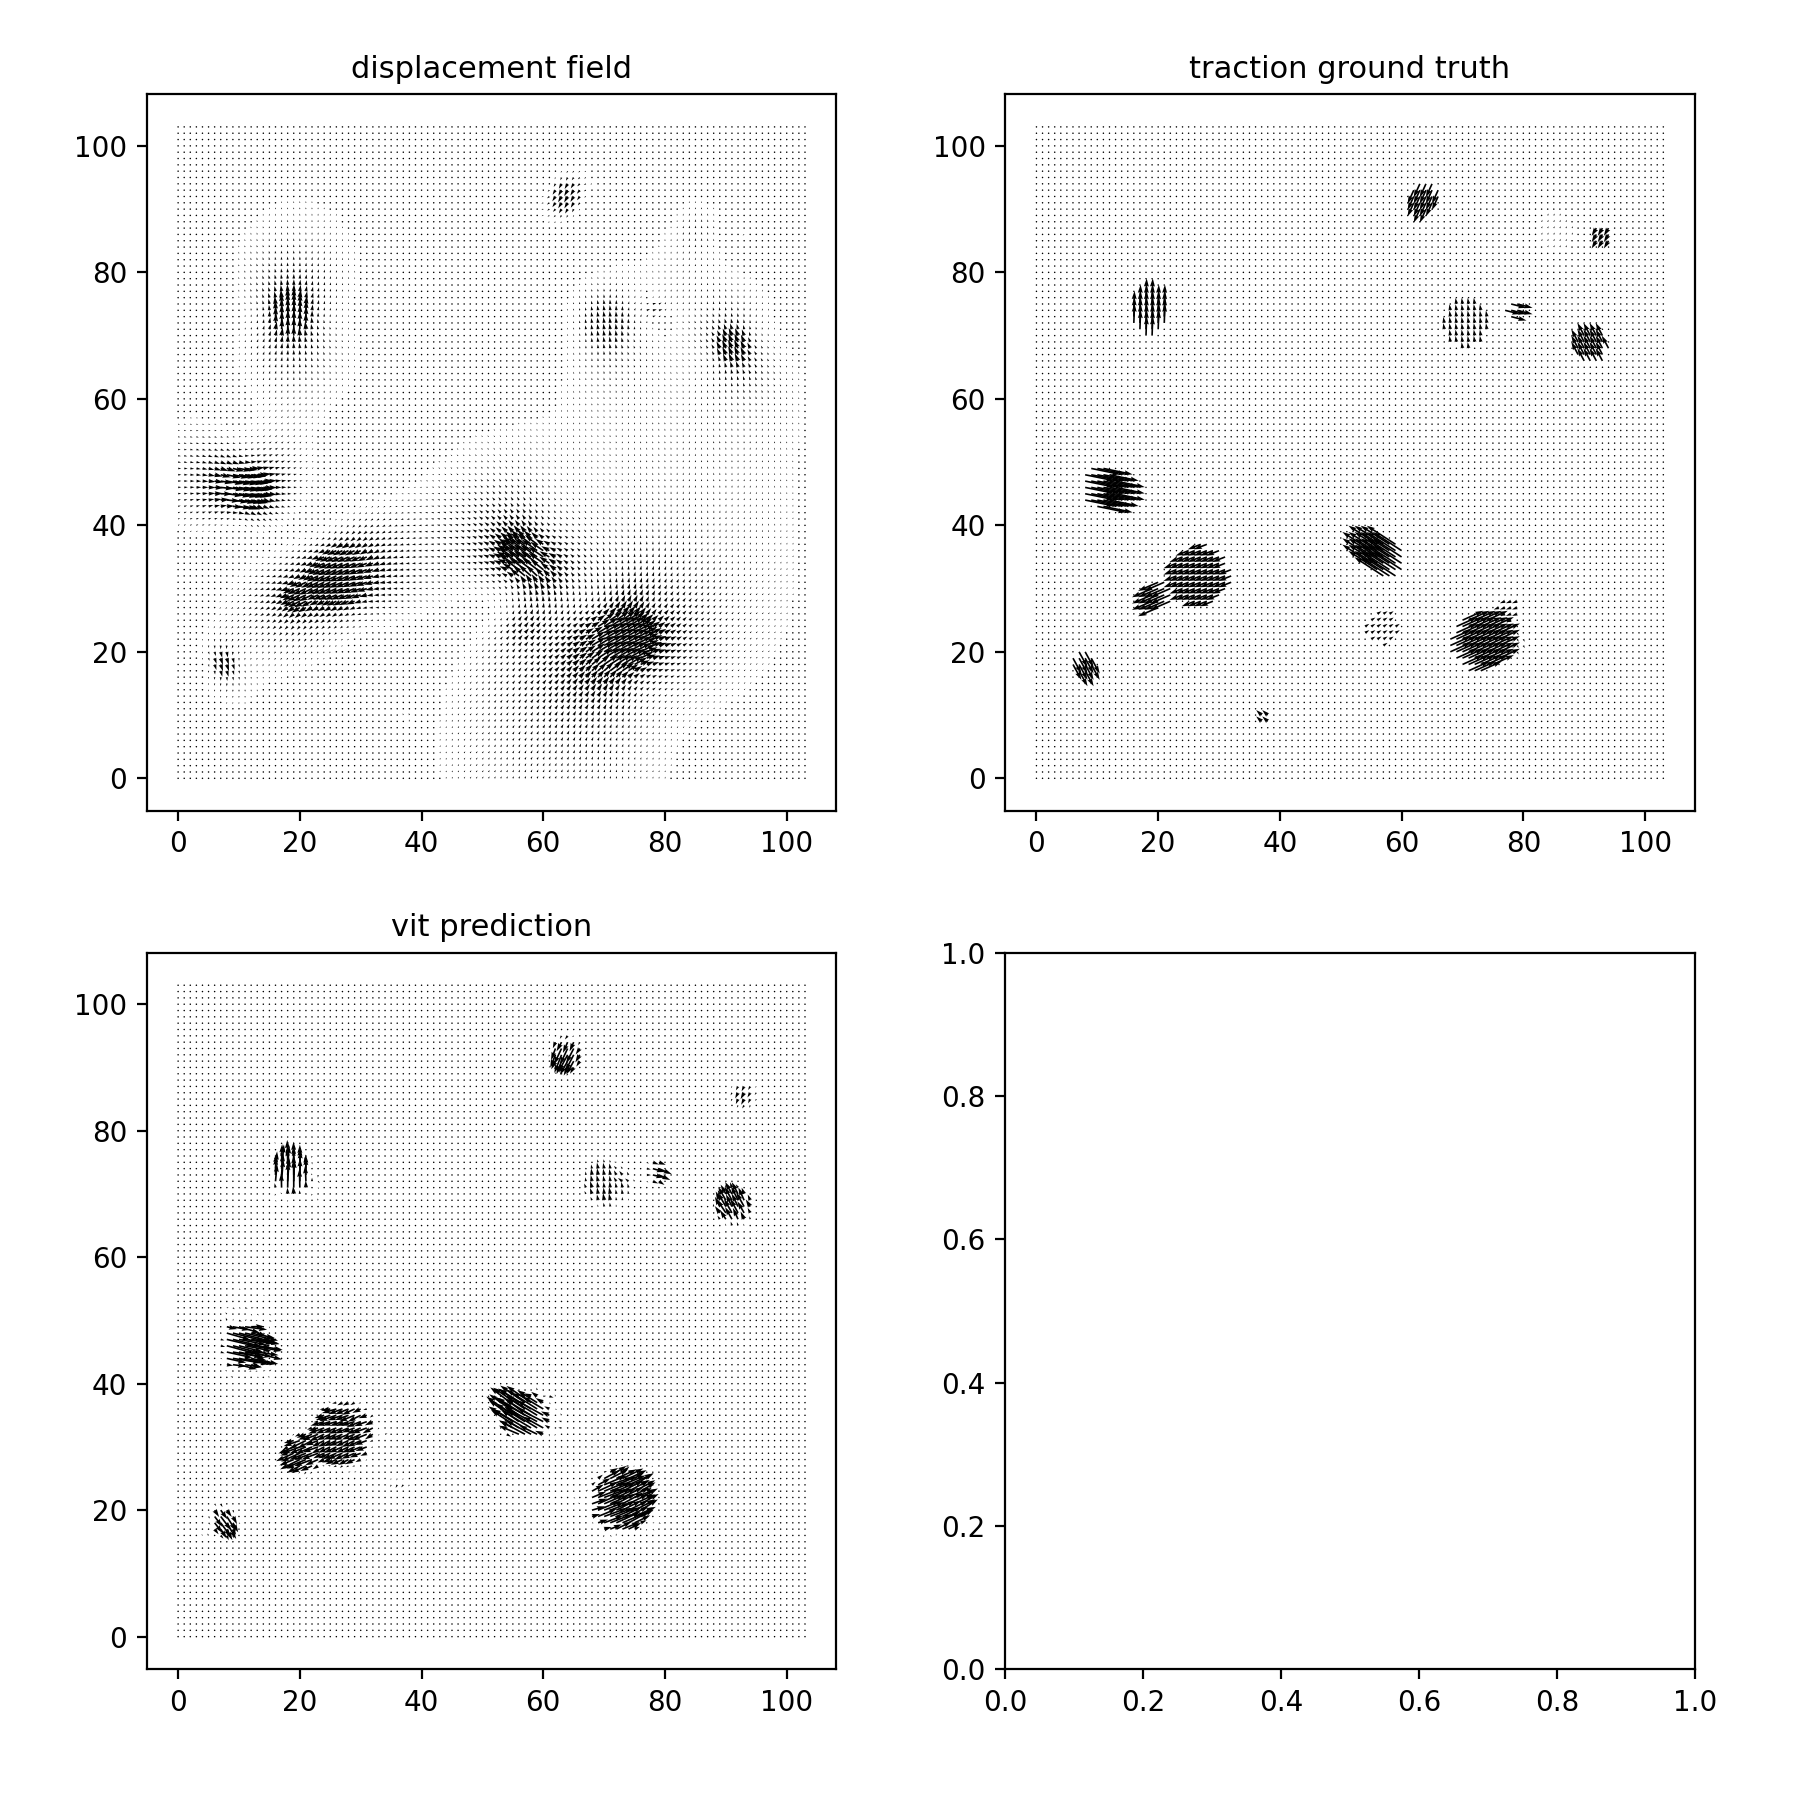

NameError: name 'pred_cnn' is not defined

In [31]:
get_ipython().run_line_magic('matplotlib', 'notebook')

# Plots
fig, axs = plt.subplots(2,2, figsize=(9, 9))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)
axs[0, 0].quiver(dspl[0,:,:,0], dspl[0,:,:,1], scale=1)
axs[0, 0].set_title('displacement field', {'fontsize': 11})

axs[0, 1].quiver(trac[0,:,:,0], trac[0,:,:,1], scale=10)
axs[0, 1].set_title('traction ground truth', {'fontsize': 11})

axs[1, 0].quiver(pred_vit[0,0,:,:].detach().numpy(), pred_vit[0,1,:,:].detach().numpy(), scale=10)
axs[1, 0].set_title('vit prediction', {'fontsize': 11})

axs[1, 1].quiver(pred_cnn[0,:,:,0], pred_cnn[0,:,:,1], scale=10)
axs[1, 1].set_title('cnn prediction', {'fontsize': 11})

In [32]:
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"